In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rpy2.robjects as robj
from mrashpen.inference.mrash_wrapR import MrASHR

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [3]:
'''
get exact same X and y with the same seed as used by Peter.
https://github.com/pcarbo/mr-ash/blob/master/scripts/
'''

# Simulate data from the linear regression model y = x1*b1 + x2*b2 + e,
# e ~ N(0,1) with b1 = 0.1, b2 = 0.1.

n = 1000
seed = 1
robj.r('set.seed({})'.format(seed))
x0 = np.array(robj.r.rnorm(n))
X  = np.vstack((x0, x0)).T
beta = np.array([0.4, 0.1])
yerr = robj.r.rnorm(n)
y    = np.dot(X, beta) #+ np.array(yerr)

In [4]:
sk2 = np.array([0, 1, 2])
sk  = np.sqrt(sk2)
wk  = np.array([0, 0.5, 0.5])

In [5]:
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, s2init = 1, winit = wk, update_pi = False, update_sigma2 = False, maxiter = 8000)
print (mrash_r.coef)

Mr.ASH terminated at iteration 6914.
[0.24991724 0.24989804]


In [6]:
from gradvi.models import elbo_nmeans
from gradvi.priors import Ash

In [7]:
prior = Ash(sk, wk = wk, scaled = False)

In [8]:
elbo_nmeans.ash(X, y, beta, 1.0, prior)

1007.8250795087765

In [9]:
elbo_nmeans.ash2(X, y, beta, 1.0, prior)

1007.8250795087765

In [10]:
from gradvi.models import coordinate_ascent_step as cdstep
cdstep.elbo(X, y, beta, 1.0, sk, wk)

926.3155488357486

In [21]:
b_seq = np.linspace(-0.1, 0.6, 50)
b_seq

array([-1.00000000e-01, -8.57142857e-02, -7.14285714e-02, -5.71428571e-02,
       -4.28571429e-02, -2.85714286e-02, -1.42857143e-02, -1.38777878e-17,
        1.42857143e-02,  2.85714286e-02,  4.28571429e-02,  5.71428571e-02,
        7.14285714e-02,  8.57142857e-02,  1.00000000e-01,  1.14285714e-01,
        1.28571429e-01,  1.42857143e-01,  1.57142857e-01,  1.71428571e-01,
        1.85714286e-01,  2.00000000e-01,  2.14285714e-01,  2.28571429e-01,
        2.42857143e-01,  2.57142857e-01,  2.71428571e-01,  2.85714286e-01,
        3.00000000e-01,  3.14285714e-01,  3.28571429e-01,  3.42857143e-01,
        3.57142857e-01,  3.71428571e-01,  3.85714286e-01,  4.00000000e-01,
        4.14285714e-01,  4.28571429e-01,  4.42857143e-01,  4.57142857e-01,
        4.71428571e-01,  4.85714286e-01,  5.00000000e-01,  5.14285714e-01,
        5.28571429e-01,  5.42857143e-01,  5.57142857e-01,  5.71428571e-01,
        5.85714286e-01,  6.00000000e-01])

In [22]:
b1, b2 = np.meshgrid(b_seq, b_seq)
b_grid = np.stack((b1, b2))

ix = b_grid.shape[1]
iy = b_grid.shape[2]
elbo_grid = np.zeros((ix, iy))
for i in range(ix):
    for j in range(iy):
        b_point = b_grid[:, i, j]
        elbo_grid[i, j] = elbo_nmeans.ash(X, y, b_point, 1.0, prior)
        #elbo_grid[i, j] = cdstep.elbo(X, y, b_point, 1.0, sk, wk)

In [24]:
np.min(elbo_grid)

995.5220598556131

In [25]:
np.max(elbo_grid)

1134.3551550219686

In [26]:
zmin = np.min(elbo_grid) - 1 * np.std(elbo_grid)
zmax = np.max(elbo_grid) + 1 * np.std(elbo_grid)
clevels = np.linspace(zmin, zmax, 50)

In [27]:
max_idx = np.unravel_index(np.argmax(elbo_grid, axis = None), elbo_grid.shape)
min_idx = np.unravel_index(np.argmin(elbo_grid, axis = None), elbo_grid.shape)

In [28]:
max_idx

(49, 49)

In [29]:
elbo_grid[max_idx]

1134.3551550219686

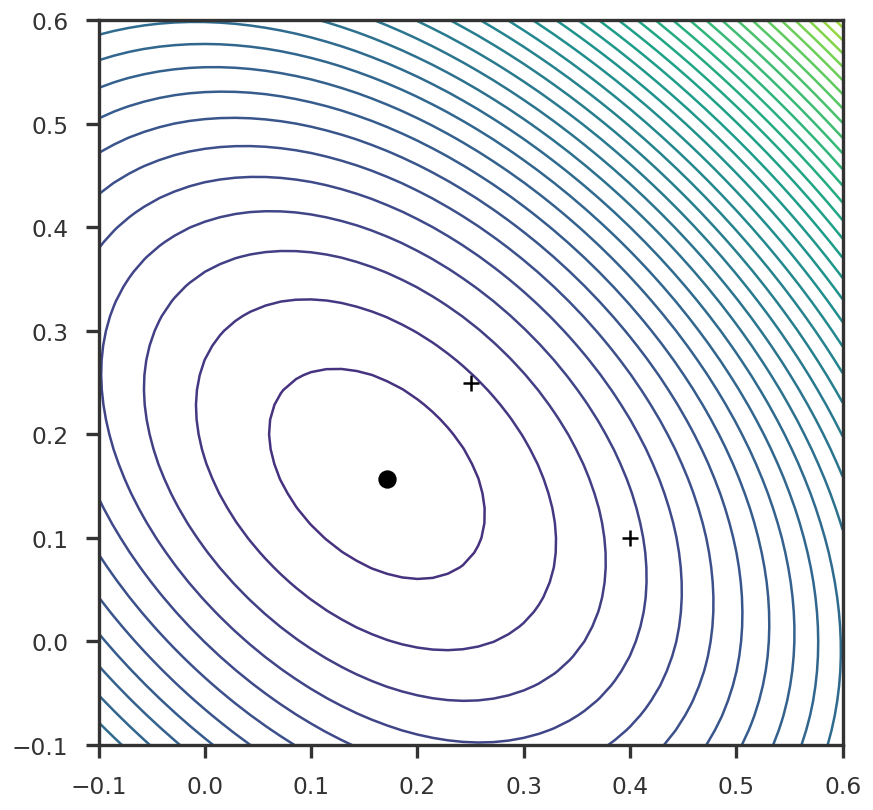

In [30]:
xx, yy = b_grid
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.contour(xx, yy, elbo_grid, clevels)
ax1.scatter(xx[min_idx], yy[min_idx], color = 'k', s = 100, zorder = 100)
ax1.scatter(beta[0], beta[1], color = 'k', marker = '+', s = 100, zorder = 100)
ax1.scatter(mrash_r.coef[0], mrash_r.coef[1], color = 'k', marker = '+', s = 100, zorder = 100)
plt.show()

In [46]:
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, binit = [-0.2, -0.2], s2init = 1, winit = wk, update_pi = False, update_sigma2 = False, maxiter = 1)
mrash_r.obj_path

Mr.ASH terminated at iteration 1.


[1466.5301578817532]

In [22]:
beta

array([0.1, 0.1])

In [19]:
b_grid[:, 0, 10]

array([0.40816327, 0.        ])

In [17]:
b_grid[1, 0, 10]

0.0

In [25]:
from gradvi.normal_means import NormalMeans

dj = np.sum(np.square(X), axis = 0)
nmash = NormalMeans(beta, prior, 1.0 / dj, scale = 1.0, d = dj)

In [26]:
nmash.posterior()

ValueError: shape mismatch: value array of shape (2,3) could not be broadcast to indexing result of shape (2,2)

In [27]:
nmash._n

2

In [28]:
nmash._k

3

In [29]:
nmash._v2

array([[9.34478634e-04, 1.00093448e+00, 2.00093448e+00]])

In [30]:
tmp = np.square(nmash._sk).reshape(1, nmash._k) / nmash._v2

In [31]:
nmash._nonzero_widx

array([1, 2])

In [32]:
nmash._sj2

0.0009344786344369904

In [39]:
nmash._y.reshape(nmash._n, 1)

array([0.1, 0.1])

In [40]:
import numbers
sj2 = nmash._sj2
if isinstance(sj2, numbers.Real):
    sj2 = np.repeat(sj2, nmash._n)
var = tmp * sj2.reshape(nmash._n, 1)
mu  = tmp * nmash._y.reshape(nmash._n, 1)

In [41]:
zjk  = np.zeros((nmash._n, nmash._k)) 
phi  = np.zeros((nmash._n, nmash._k)) 
inz  = nmash._nonzero_widx
zjk[:, inz] = nmash.logLjk()[:, inz] + np.log(nmash._wk[inz])

In [42]:
zjk

array([[ 0.        , -0.69860953, -1.04245317],
       [ 0.        , -0.69860953, -1.04245317]])

In [43]:
phi[:, inz] = np.exp(zjk - np.max(zjk, axis = 1, keepdims = True))

ValueError: shape mismatch: value array of shape (2,3) could not be broadcast to indexing result of shape (2,2)

In [46]:
np.exp(zjk - np.max(zjk, axis = 1, keepdims = True))

array([[1.        , 0.49727627, 0.35258866],
       [1.        , 0.49727627, 0.35258866]])

In [34]:
phi        /= np.sum(phi, axis = 1, keepdims = True)

1070.1154238828426

In [35]:
dj

array([1070.11542388, 1070.11542388])

In [36]:
nmash._is_homogeneous

True